# File to process data from our open survey (e. g. reddit)
## from importing data to processing and visualizing


In [22]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Importing data

In [23]:
# Importing data
df_reddit_data = pd.read_csv('data/umfrage-nachhaltige-mobilitaet_offen.csv')

## Methods for data processing

In [24]:
#Constants for column names
COLUMN_NAMES = {
    'age': 'Wie alt sind Sie? ',
    'employment': 'Wie ist Ihre Beschäftigung? ',
    'monthly_income': 'Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)',
    'car_ownership': 'Besitzen Sie ein Auto? (auch Leasing) ',
    'interest_e_car': 'Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte) ',
    'living_situation': 'Wie ist Ihre Wohnsituation? (Wohneigentum?) ',
    'living_situation_house_apartment': 'Wie ist Ihre Wohnsituation? (Haus oder Wohnung?) ',
    'living_situation_city': 'Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?) ',
    'mobility_car': 'Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus) ',
    'mobility_public_transport': 'Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus? ',
    'mobility_public_transport_attraction': 'Was würde den ÖPNV für Sie attraktiver machen? ',
    'mobility_e_car_attraction': 'Was würde E-Autos für Sie attraktiver machen? '
}
age = 'Wie alt sind Sie? '
employment = 'Wie ist Ihre Beschäftigung? '
monthly_income = 'Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)'
car_ownership = 'Besitzen Sie ein Auto? (auch Leasing) '
interest_e_car = 'Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte) '
living_situation = 'Wie ist Ihre Wohnsituation? (Wohneigentum?) '
living_situation_house_apartment = 'Wie ist Ihre Wohnsituation? (Haus oder Wohnung?) '
living_situation_city = 'Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?) '
mobility_car = 'Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus) '
mobility_public_transport = 'Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus? '
mobility_public_transport_attraction = 'Was würde den ÖPNV für Sie attraktiver machen? '
mobility_e_car_attraction = 'Was würde E-Autos für Sie attraktiver machen? '

In [25]:
def explore_data(input_data):
    #Display a summary of the data
    # args: data: pandas dataframe
    # Summarize the data
    print(input_data.info())
    # Display the first 5 rows of the data
    print(input_data.head())
    
def drop_data(input_data):
    # Drop non-uniques and missing values
    # args: data: pandas dataframe
    # Drop duplicates
    duplicate_free_data = input_data.drop_duplicates()
    # Drop missing values
    na_free_data = duplicate_free_data.dropna(inplace=True)
    # Replace missing values with the mean
    return na_free_data

def fill_data(input_data):
    # Fill missing values with the mean
    # args: data: pandas dataframe
    #data.fillna(data.mean(), inplace=True)
    input_data.ffill().bfill()
    return input_data

# normalise age ranges to class representation
def normalise_age(input_data):
    # normalise age ranges to class representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    input_data[age] = input_data[age].replace(['0-15', '16-19', '20-25', '26-35', '36-45', '46-55', '56-65', '65+'], [7.5, 17.5, 22.5, 30.5, 40.5, 50.5, 60.5, 65])
    return input_data

# percent to numerical representation
def normalise_percent(input_data):
    # normalise percent to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    percentage_mapping = {
        '0%': 0,
        '10%': 10,
        '20%': 20,
        '30%': 30,
        '40%': 40,
        '50%': 50,
        '60%': 60,
        '70%': 70,
        '80%': 80,
        '90%': 90,
        '100%': 100
    }
    input_data[mobility_car] = input_data[mobility_car].replace(percentage_mapping)
    input_data[mobility_public_transport] = input_data[mobility_public_transport].replace(percentage_mapping)
    return input_data

def fill_missing_values(input_data, columns):
    # fill missing values with the mean
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    imputed_data = input_data.copy()
    imputer = KNNImputer(n_neighbors=3)
    
    # Ensure columns are reshaped correctly
    reshaped_column = input_data[columns]
    imputed_column = pd.DataFrame(imputer.fit_transform(reshaped_column), columns=columns)
    imputed_data[columns] = imputed_column
    
    return imputed_data
    

# remove euro sign from monthly income
def normalise_monthly_income(input_data):
    # remove euro sign from monthly income
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    input_data[monthly_income] = input_data[monthly_income].replace('€', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(' euro', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(' Netto', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace('netto: ', '', regex=True)
    input_data[monthly_income] = input_data[monthly_income].replace(',', '.', regex=True)
    # convert to float for this input data
    input_data[monthly_income] = input_data[monthly_income].replace('Einkommen als SHK 300. Eltern 600', '900', regex=True)
    # fill missing values with the median
    input_data[monthly_income] = input_data[monthly_income].fillna(input_data[monthly_income].median())
    input_data[monthly_income] = input_data[monthly_income].astype(float)
    return input_data

def normalise_employment(input_data):
    # normalise employment to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    employment_mapping = {
        'Student': 1,
        'Angestellter': 2,
        'Selbstständiger': 3,
        'Arbeitslos': 4,
        'Rentner': 5,
        'Schüler': 6,
        'Azubi': 7,
        'dualer Student (impliziert Anstellung bei einem Partner Unternehmen)': 8,
        'Beamter': 9,
        'Student;Angestellter': 10,
    }
    input_data[employment] = input_data[employment].replace(employment_mapping)
    return input_data

def normalise_living_situation(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Wohneigentum': 1,
        'gemietet': 2,
    }
    input_data[living_situation] = input_data[living_situation].replace(living_mapping)
    return input_data

def normalise_living_situation_house_apartment(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Haus': 1,
        'Wohnung': 2,
        'Reihenhaus': 3,
        'Doppelhaushälfte': 4,
    }
    input_data[living_situation_house_apartment] = input_data[living_situation_house_apartment].replace(living_mapping)
    return input_data

def normalise_living_situation_city(input_data):
    # normalise living situation to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    living_mapping = {
        'Großstadt (min. 100.000 Einwohner)': 1,
        'Stadt': 2,
        'Land': 3
    }
    input_data[living_situation_city] = input_data[living_situation_city].replace(living_mapping)
    return input_data

# normalise car ownership to numerical representation
def normalise_car_ownership(input_data):
    # normalise car ownership to numerical representation
    # args: data: pandas dataframe
    # return: data: pandas dataframe
    input_data[car_ownership] = input_data[car_ownership].replace(['Auto', 'kein Auto', 'E-Auto'], [1, 0, 2])
    return input_data

def split_data(input_data):
    # split data for use case
    # args: data: pandas dataframe
    # Split the data into features and target
    # helper method to split the data in different use cases, not used in this notebook
    data_na_removed = input_data.dropna()
    selected_columns_finance = [age, employment, monthly_income, car_ownership, interest_e_car]
    selected_columns_mobility = [age, car_ownership, interest_e_car, mobility_car, mobility_public_transport, mobility_public_transport_attraction, mobility_e_car_attraction]
    selected_columns_living = [living_situation, living_situation_house_apartment, living_situation_city, interest_e_car] 
    selected_columns_age_employment = [age, employment, interest_e_car] 
    data_financial = input_data[selected_columns_finance]
    data_mobility = input_data[selected_columns_mobility]
    data_living = input_data[selected_columns_living]
    data_age = input_data[selected_columns_age_employment]
    return input_data, data_na_removed, data_financial, data_mobility, data_living, data_age

def prepare_data(input_data, feature_columns, target):
    # Prepare the data for analysis
    # args: data: pandas dataframe
    # args: feature_column: (list): liste der spalten die als feature genutzt werden sollen
    # args: target_column: (string): name zielvariable
    #return: tuple: X_train, X_test, y_train, y_test
    X_var = input_data[feature_columns]
    Y_var = input_data[target]
    # Split the data into training and testing data
    X_trains, X_tests, y_train, y_test = train_test_split(X_var, Y_var, test_size=0.2, random_state=42)
    return X_trains, X_tests, y_train, y_test

def scale_data(X_train_data, X_test_data):
    # Scale the data
    # args: X_train: pandas dataframe
    # args: X_test: pandas dataframe
    #return: X_train_scaled, X_test_scaled
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_data)
    X_test_scaled = scaler.transform(X_test_data)
    return X_train_scaled, X_test_scaled

def train_model(X_train_data, y_train_data):
    # Train the model
    # args: X_train: pandas dataframe
    # args: y_train: pandas dataframe
    #return: model
    model = LinearRegression()
    model.fit(X_train_data, y_train_data)
    return model

def evaluate_model(model, X_test_data, y_test_data):
    # Evaluate the model
    # args: model: model
    # args: X_test: pandas dataframe
    # args: y_test: pandas dataframe
    y_pred = model.predict(X_test_data)
    mse = mean_squared_error(y_test_data, y_pred)
    return mse

def analyze_data(X_train_data, X_test_data, Y_train_data, Y_test_data):
    # Analyze the data
    # args: X_train: pandas dataframe
    # args: X_test: pandas dataframe
    # args: Y_train: pandas dataframe
    # args: Y_test: pandas dataframe
    #return: mse
    model = LinearRegression()
    model.fit(X_train_data, Y_train_data)
    y_pred = model.predict(X_test_data)
    mse = mean_squared_error(Y_test_data, y_pred)
    print('Mean Squared Error:', mse)
    return mse

def visualize_correlation(input_data):
    # args: data: pandas dataframe
    # args: feature_columns: (list): liste der spalten die als feature genutzt werden sollen
    # args: target_column: (string): name zielvariable
    #return: None
    # drop the 'Zeitstempel' column
    input_data_copy = input_data.copy()
    input_data_copy = input_data_copy.drop('Zeitstempel', axis=1)
    input_data_copy = input_data_copy.drop(mobility_public_transport_attraction, axis=1)
    input_data_copy = input_data_copy.drop(mobility_e_car_attraction, axis=1)
    correlation_matrix = input_data_copy.corr()
    plt.figure(figsize=(12, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

In [26]:
# method for linear regression analysis using scikit-learn
def linear_regression_analysis(input_data, feature_column, target): 
    # Split the data
    sns.lmplot(x = feature_column, y = target, data = input_data, order = 2, ci = None)
    plt.show()
    input_data.ffill().bfill()
    x = np.array(input_data[feature_column]).reshape(-1, 1)
    y = np.array(input_data[target]).reshape(-1, 1)
 
    # Separating the data into independent and dependent variables
    # Converting each dataframe into a numpy array 
    # since each dataframe contains only one column
 
    # Dropping any rows with Nan values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
 
    # Splitting the data into training and testing data
    regr = LinearRegression()
 
    regr.fit(x_train, y_train)
    print(regr.score(x_test, y_test))
    y_pred = regr.predict(x_test)
    plt.scatter(x_test, y_test, color ='b')
    plt.plot(x_test, y_pred, color ='k')
    # label the plot
    plt.xlabel(feature_column)
    plt.ylabel(target)
 
    plt.show()
    # Data scatter of predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    return None

In [27]:
# method for linear regression analysis using scikit-learn for multiple features
def linear_regression_analysis_multiple_features(input_data, feature_columns, target):
    # Split the data
    #sns.lmplot(x = feature_column, y = target, data = input_data, order = 2, ci = None)
    #plt.show()
    input_data.ffill().bfill()
    x = np.array(input_data[feature_columns])
    y = np.array(input_data[target])
 
    # Separating the data into independent and dependent variables
    # Converting each dataframe into a numpy array 
    # since each dataframe contains only one column
    #input_data.dropna(inplace = True)
 
    # Dropping any rows with Nan values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
 
    # Splitting the data into training and testing data
    regr = LinearRegression()
 
    regr.fit(x_train, y_train)
    print(regr.score(x_test, y_test))
    y_pred = regr.predict(x_test)
    plt.scatter(x_test, y_test, color ='b')
    plt.plot(x_test, y_pred, color ='k')
    # adjust the plot to show multiple features or a combination of features
    #plt.plot(x_test, y_pred, color ='k')
 
    #plt.show()
    # Data scatter of predicted values
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()
    return None

## Data Exploration

In [28]:
df_reddit_data.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 13 columns):
 #   Column                                                                                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                                                                                        --------------  -----  
 0   Zeitstempel                                                                                                                                                                   12 non-null     object 
 1   Wie alt sind Sie?                                                                                                                                                             12 non-null     object 
 2   Wie ist Ihre Wohnsituation? (Wohneigentum?)                                     

,Zeitstempel,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?,Was würde den ÖPNV für Sie attraktiver machen?,Was würde E-Autos für Sie attraktiver machen?
0,2024/04/23 8:42:15 PM OEZ,26-35,Wohneigentum,Haus,Land,Angestellter,NaN,Auto,2.0,90%,10%,Überhaupt verfügbar sein,mehr/besser verteilte Lademöglichkeiten;mehr R...
1,2024/04/23 8:48:51 PM OEZ,36-45,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,1900 euro,kein Auto,9.0,0%,20%,günstigere Preise;bessere Zuverlässigkeit,günstigere Preise;mehr/besser verteilte Lademö...
2,2024/04/23 9:04:08 PM OEZ,16-19,Wohneigentum,Haus,Stadt,Student,NaN,kein Auto,7.0,0%,80%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,günstigere Preise;mehr/besser verteilte Lademö...
3,2024/04/23 9:12:42 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student,NaN,kein Auto,4.0,0%,100%,günstigere Preise;kürzere Wartezeit zwischen z...,mehr/besser verteilte Lademöglichkeiten;mehr R...
4,2024/04/24 12:56:44 AM OEZ,20-25,gemietet,Wohnung,Stadt,Student,NaN,Auto,8.0,90%,10%,günstigere Preise;bessere Zuverlässigkeit,günstigere Preise;gute Budget-E-Autos;mehr/bes...
5,2024/04/24 1:21:26 AM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student,1100,kein Auto,7.0,0%,90%,günstigere Preise;bessere Zuverlässigkeit,günstigere Preise;gute Budget-E-Autos;keine un...
6,2024/04/24 10:11:25 AM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student;Angestellter,"Einkommen als SHK 300, Eltern 600",kein Auto,6.0,0%,70%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;gute Budget-E-Autos;mehr/bes...
7,2024/04/24 11:55:29 AM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,3400,kein Auto,9.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...
8,2024/04/24 1:09:55 PM OEZ,26-35,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student,1900,kein Auto,NaN,0%,90%,günstigere Preise;kürzere Wartezeit zwischen z...,Ich will kein Auto
9,2024/04/24 1:50:28 PM OEZ,16-19,Wohneigentum,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,NaN,kein Auto,3.0,30%,50%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...


## #Cleaning the data

In [29]:
# Filling missing values
fill_data(df_reddit_data)

,Zeitstempel,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?,Was würde den ÖPNV für Sie attraktiver machen?,Was würde E-Autos für Sie attraktiver machen?
0,2024/04/23 8:42:15 PM OEZ,26-35,Wohneigentum,Haus,Land,Angestellter,1900 euro,Auto,2.0,90%,10%,Überhaupt verfügbar sein,mehr/besser verteilte Lademöglichkeiten;mehr R...
1,2024/04/23 8:48:51 PM OEZ,36-45,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,1900 euro,kein Auto,9.0,0%,20%,günstigere Preise;bessere Zuverlässigkeit,günstigere Preise;mehr/besser verteilte Lademö...
2,2024/04/23 9:04:08 PM OEZ,16-19,Wohneigentum,Haus,Stadt,Student,1900 euro,kein Auto,7.0,0%,80%,kürzere Wartezeit zwischen zwei Zügen/Bussen;b...,günstigere Preise;mehr/besser verteilte Lademö...
3,2024/04/23 9:12:42 PM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student,1900 euro,kein Auto,4.0,0%,100%,günstigere Preise;kürzere Wartezeit zwischen z...,mehr/besser verteilte Lademöglichkeiten;mehr R...
4,2024/04/24 12:56:44 AM OEZ,20-25,gemietet,Wohnung,Stadt,Student,1900 euro,Auto,8.0,90%,10%,günstigere Preise;bessere Zuverlässigkeit,günstigere Preise;gute Budget-E-Autos;mehr/bes...
5,2024/04/24 1:21:26 AM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student,1100,kein Auto,7.0,0%,90%,günstigere Preise;bessere Zuverlässigkeit,günstigere Preise;gute Budget-E-Autos;keine un...
6,2024/04/24 10:11:25 AM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student;Angestellter,"Einkommen als SHK 300, Eltern 600",kein Auto,6.0,0%,70%,günstigere Preise;kürzere Wartezeit zwischen z...,günstigere Preise;gute Budget-E-Autos;mehr/bes...
7,2024/04/24 11:55:29 AM OEZ,20-25,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,3400,kein Auto,9.0,0%,100%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...
8,2024/04/24 1:09:55 PM OEZ,26-35,gemietet,Wohnung,Großstadt (min. 100.000 Einwohner),Student,1900,kein Auto,9.0,0%,90%,günstigere Preise;kürzere Wartezeit zwischen z...,Ich will kein Auto
9,2024/04/24 1:50:28 PM OEZ,16-19,Wohneigentum,Wohnung,Großstadt (min. 100.000 Einwohner),Angestellter,1900,kein Auto,3.0,30%,50%,kürzere Wartezeit zwischen zwei Zügen/Bussen;g...,günstigere Preise;mehr/besser verteilte Lademö...


## Data Preprocessing

In [30]:
data_copy = normalise_age(df_reddit_data)
data_copy = normalise_monthly_income(df_reddit_data)
data_copy = normalise_car_ownership(df_reddit_data)
data_copy = normalise_employment(df_reddit_data)
data_copy = normalise_living_situation(df_reddit_data)
data_copy = normalise_living_situation_house_apartment(df_reddit_data)
data_copy = normalise_living_situation_city(df_reddit_data)
data_copy = normalise_percent(df_reddit_data)
# Filling missing values
data_copy = fill_missing_values(data_copy, [interest_e_car])

## Data Analysis

In [31]:
# Checking the distribution of the data
df_reddit_data.describe()

,Wie alt sind Sie?,Wie ist Ihre Wohnsituation? (Wohneigentum?),Wie ist Ihre Wohnsituation? (Haus oder Wohnung?),"Wie ist Ihre Wohnsituation? (Großstadt, Stadt, Land?)",Wie ist Ihre Beschäftigung?,"Bitte schätzen Sie das monatliche Netto Gesamteinkommen in Ihrem Haushalt in Euro. (Wenn Sie dazu keine Angaben machen möchten, überspringen Sie diese Frage bitte.)",Besitzen Sie ein Auto? (auch Leasing),"Wie interessiert sind Sie an einem E-Auto als Ihr nächstes(/erstes) KFZ? (Wenn Sie generell kein Interesse am Besitz eines Autos haben, überspringen Sie diese Frage bitte)","Welchen Anteil an Ihrer Gesamtmobilität macht Ihr Auto aus? (falls Sie kein Auto besitzen, wählen Sie bitte 0% aus)",Welchen Anteil an Ihrer Gesamtmobilität macht der ÖPNV aus?
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,10.000000,12.000000,12.000000
mean,24.750000,1.666667,1.833333,1.583333,2.166667,1520.000000,1.250000,5.700000,20.000000,59.166667
std,6.942949,0.492366,0.389249,0.792961,2.516611,773.234058,0.452267,2.750757,34.641016,33.967453
min,17.500000,1.000000,1.000000,1.000000,1.000000,40.000000,1.000000,2.000000,0.000000,10.000000
25%,21.250000,1.000000,2.000000,1.000000,1.000000,1400.000000,1.000000,3.250000,0.000000,35.000000
50%,22.500000,2.000000,2.000000,1.000000,1.500000,1500.000000,1.000000,6.500000,0.000000,60.000000
75%,30.500000,2.000000,2.000000,2.000000,2.000000,1600.000000,1.250000,7.750000,30.000000,90.000000
max,40.500000,2.000000,2.000000,3.000000,10.000000,3400.000000,2.000000,9.000000,90.000000,100.000000


## Data Visualization

Visualizing the data


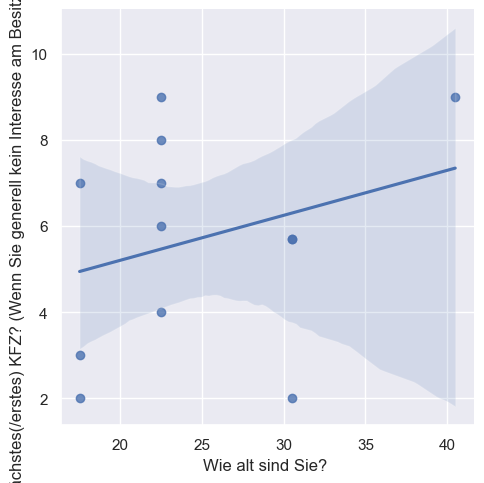

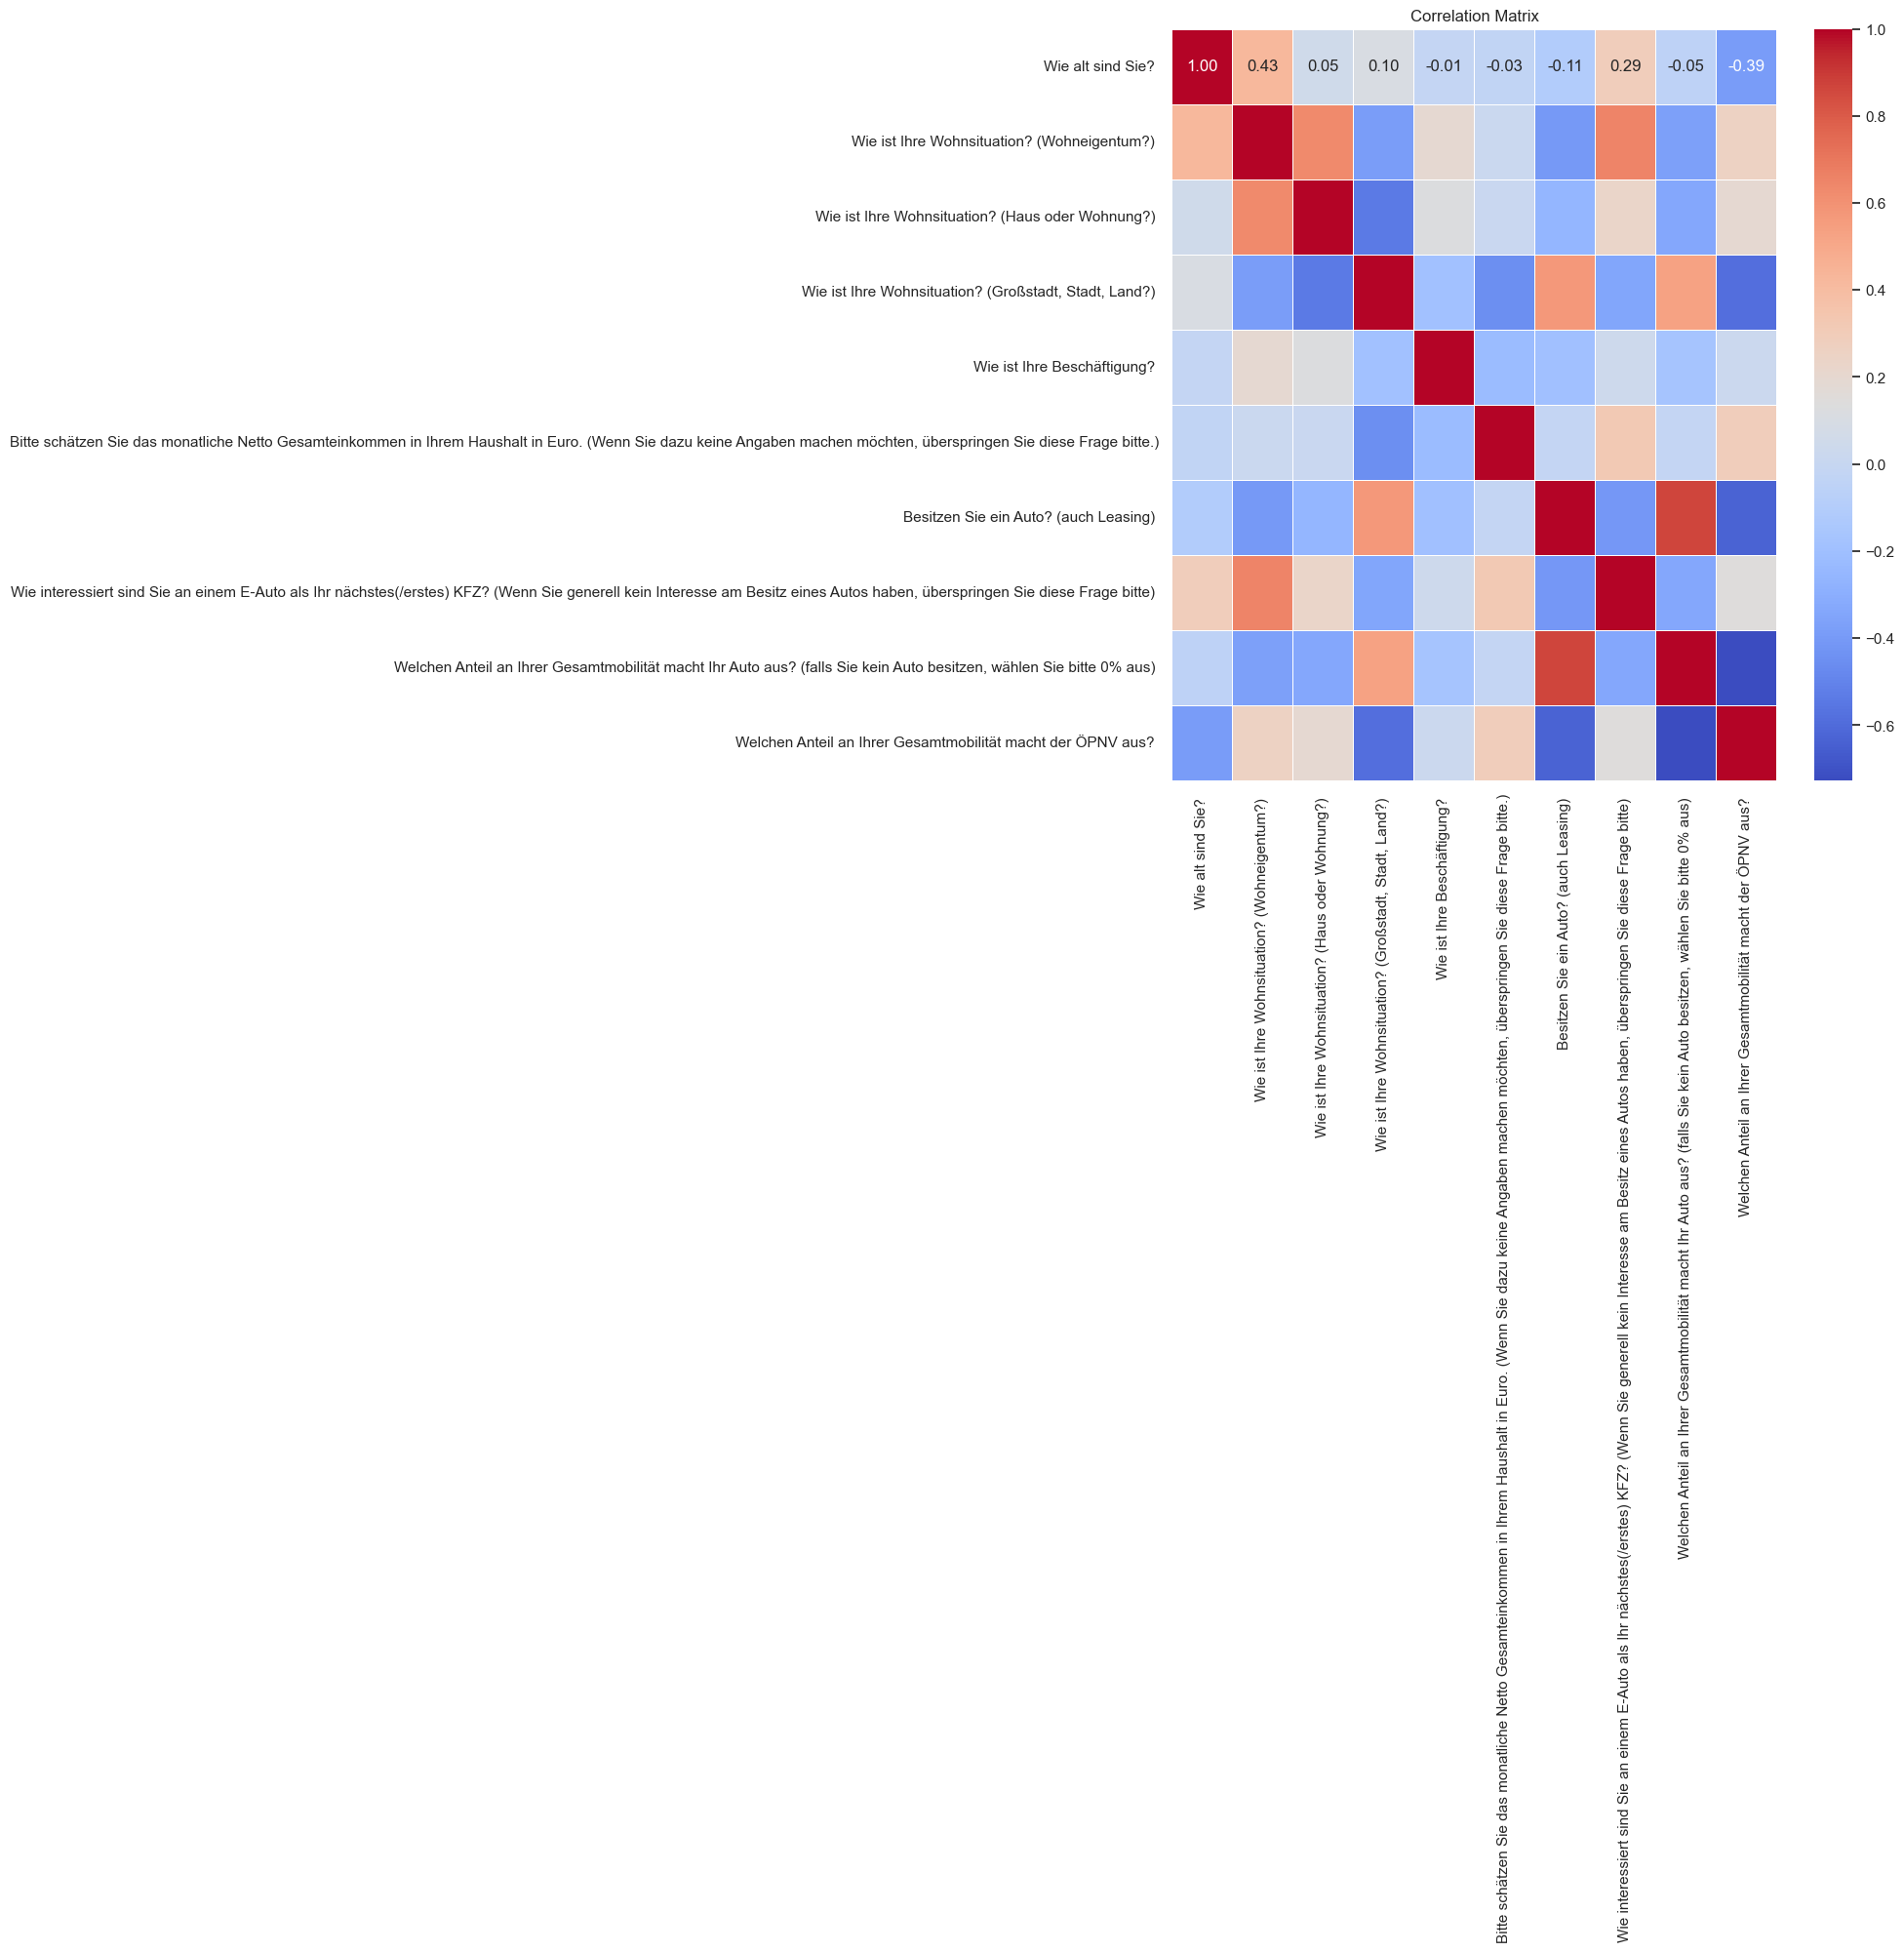

In [32]:
# Visualizing the correlation
visualize_correlation(data_copy)

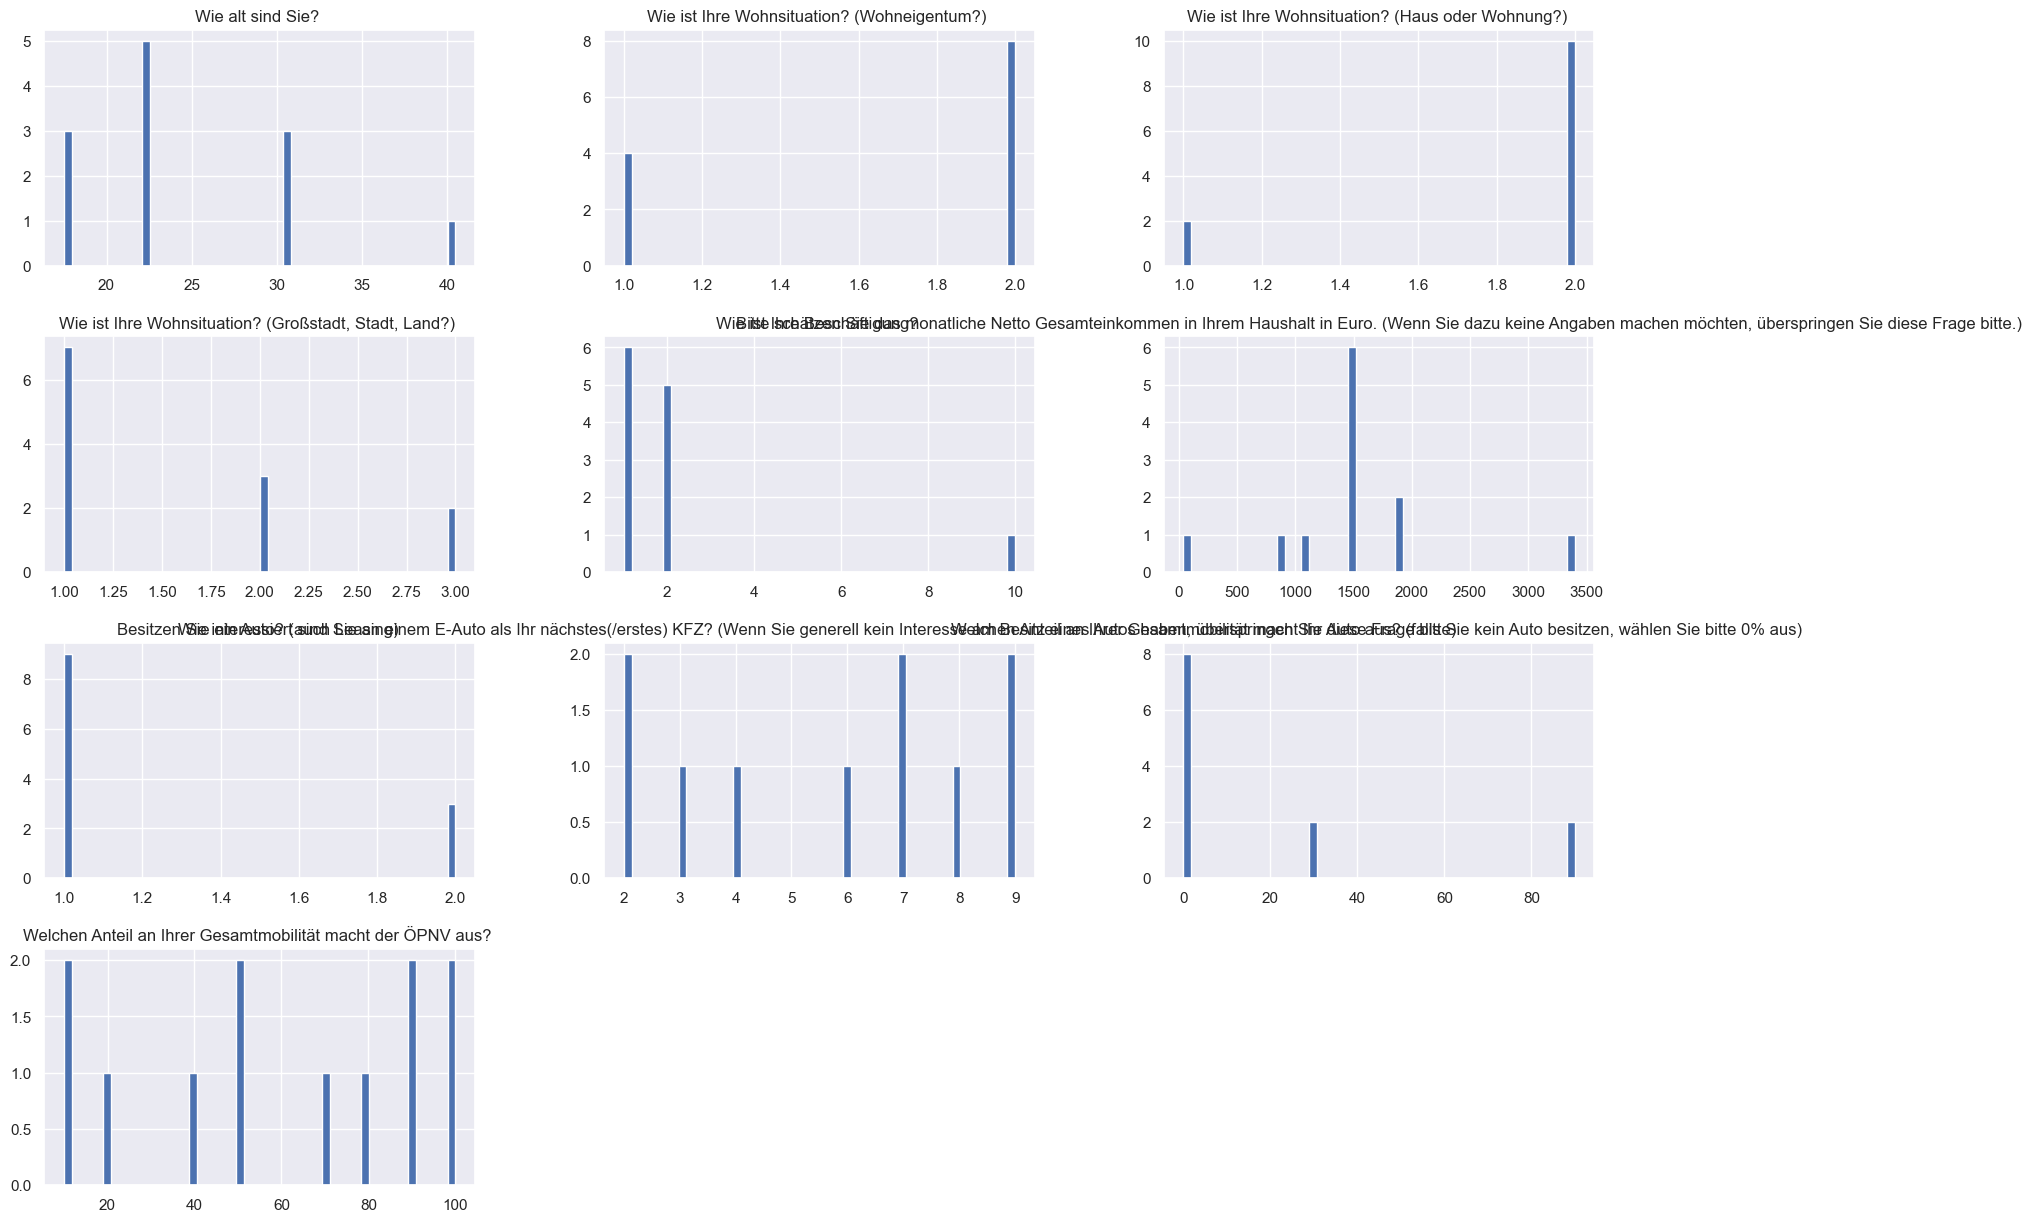

Text(0, 0.5, 'Frequency')

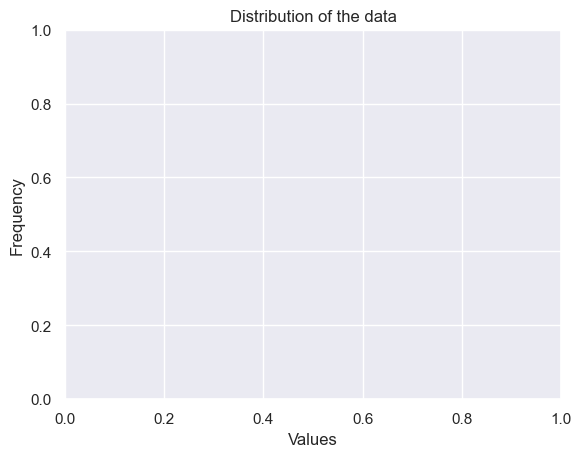

In [33]:
# Plotting the distribution of the data
df_reddit_data.hist(bins=50, figsize=(20, 15))
plt.show()
# add seaborn style
sns.set()
# add title and description
plt.title('Distribution of the data')
plt.xlabel('Values')
plt.ylabel('Frequency')


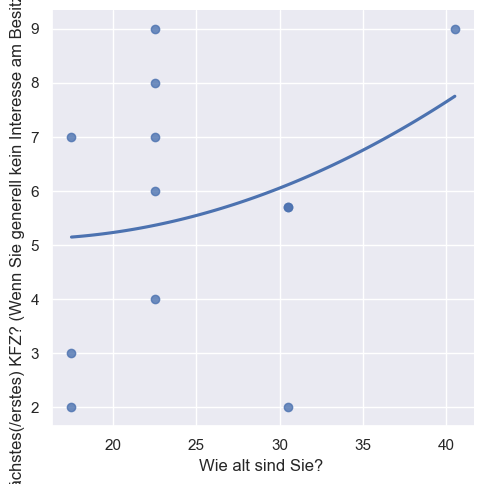

-24.566052067071563


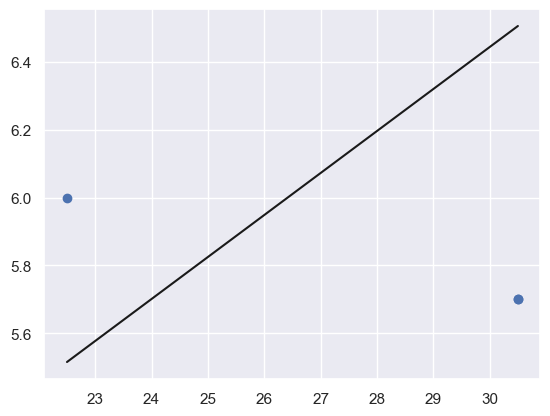

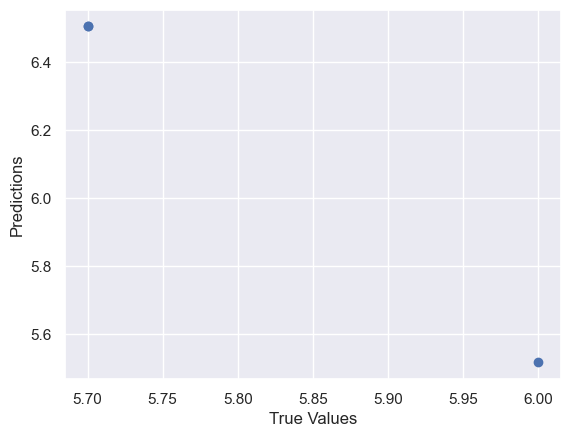

In [34]:
# linear regression analysis age vs interest in e-car
linear_regression_analysis(data_copy, age, interest_e_car)

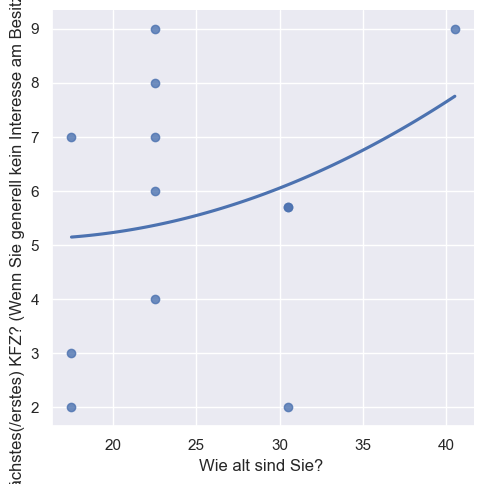

-0.3524274312866278


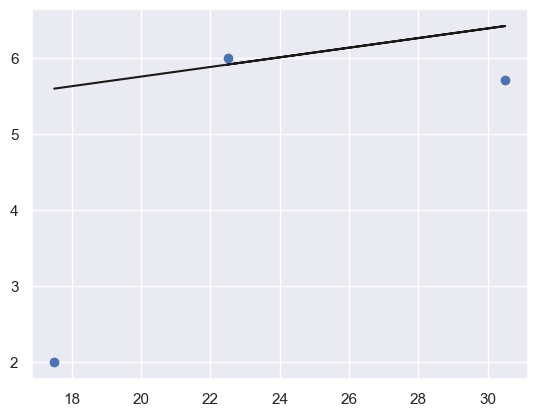

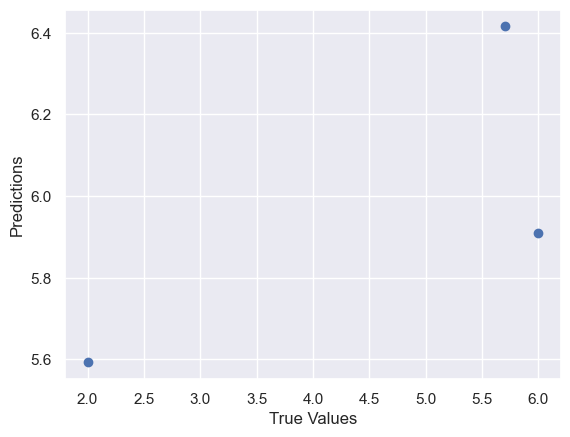

In [35]:
# linear regression analysis monthly income vs interest in e-car
linear_regression_analysis(data_copy, monthly_income, interest_e_car)

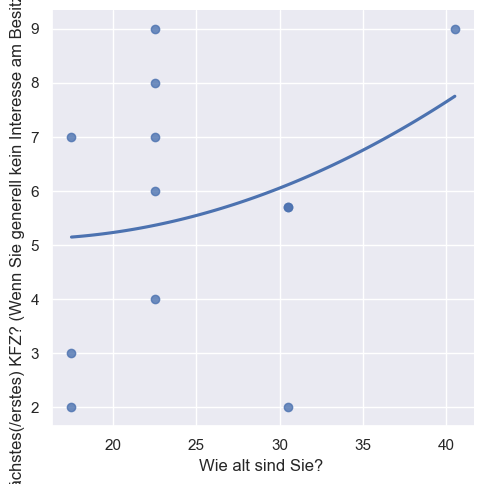

-0.2398311141677234


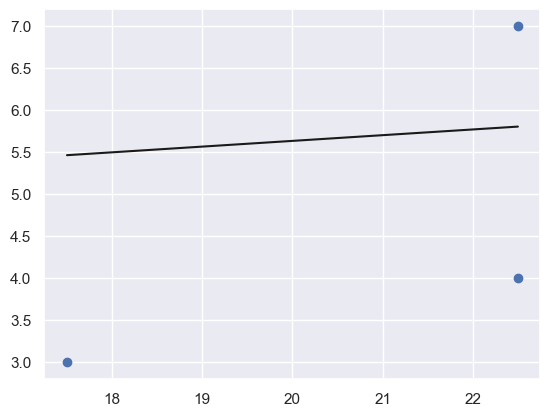

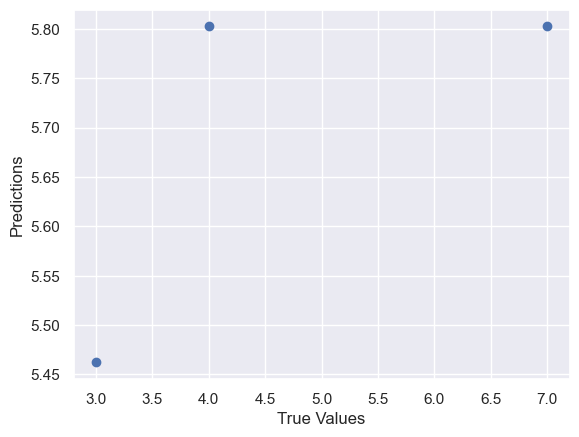

In [36]:
# linear regression analysis car ownership vs interest in e-car
linear_regression_analysis(data_copy, car_ownership, interest_e_car)

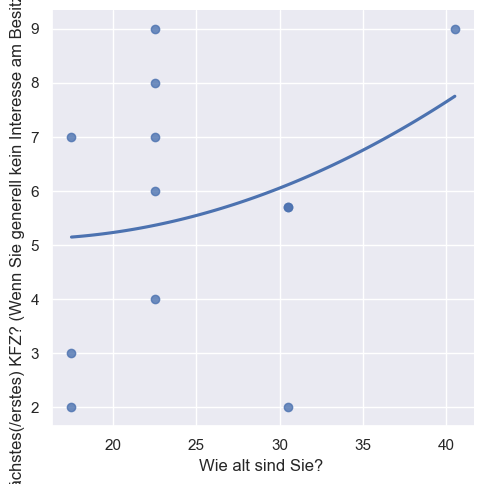

0.045345668343211076


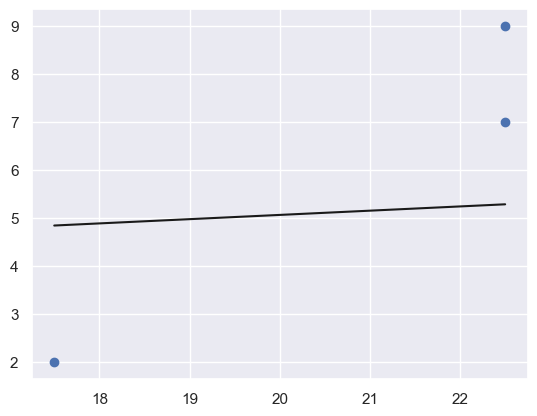

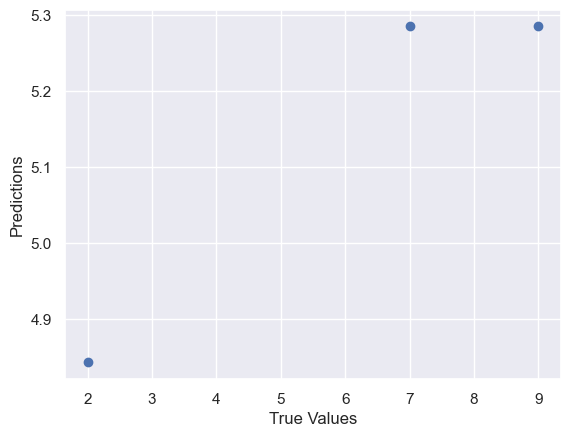

In [37]:
linear_regression_analysis(data_copy, employment, interest_e_car)

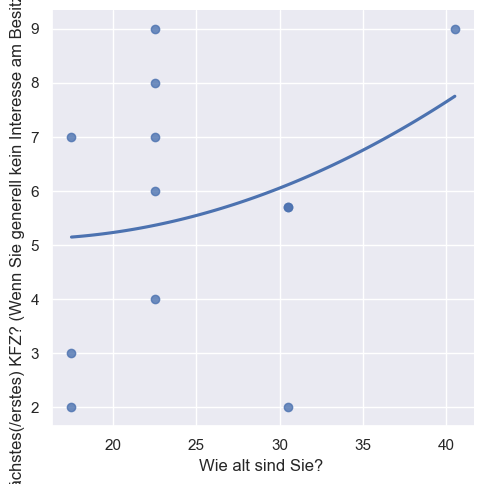

0.027165877551020734


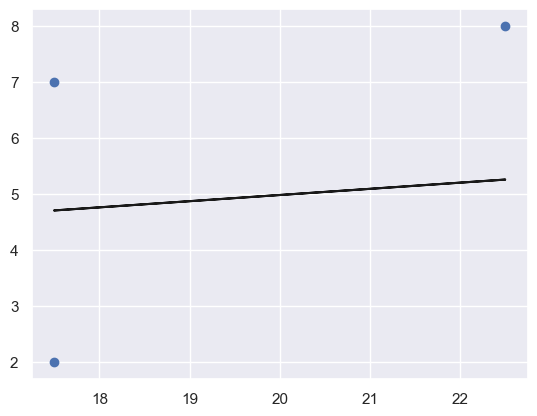

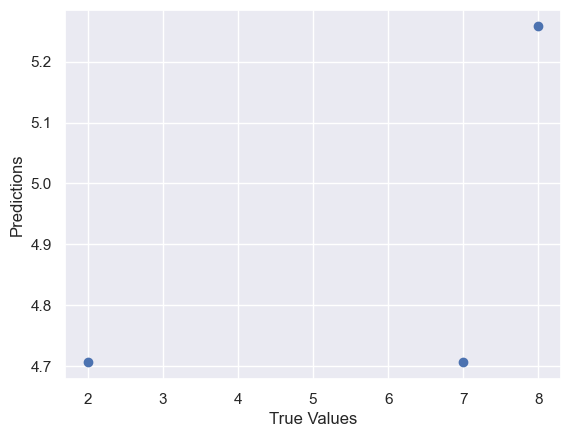

In [38]:
linear_regression_analysis(data_copy, living_situation, interest_e_car)

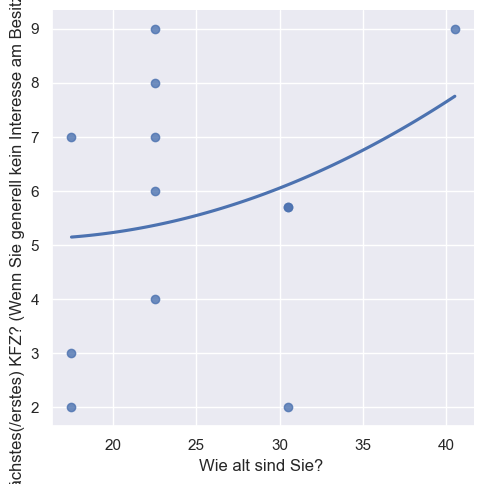

-0.6506880166885576


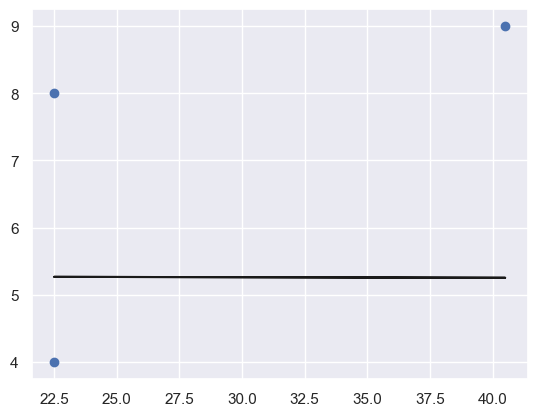

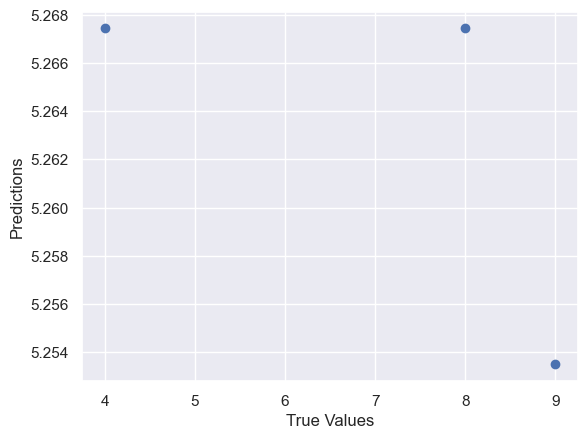

In [39]:
linear_regression_analysis(data_copy, living_situation_house_apartment, interest_e_car)

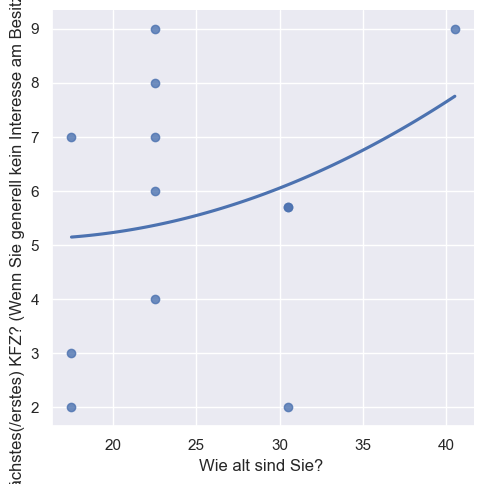

-0.09819253899612601


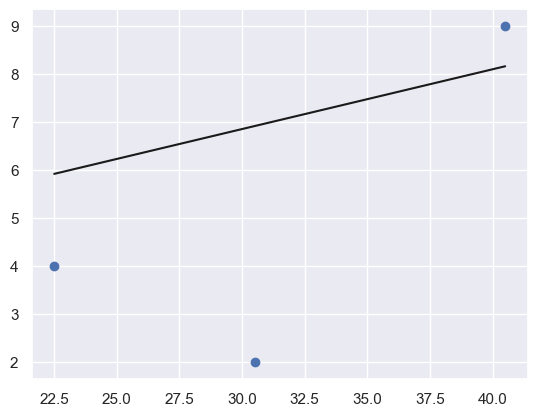

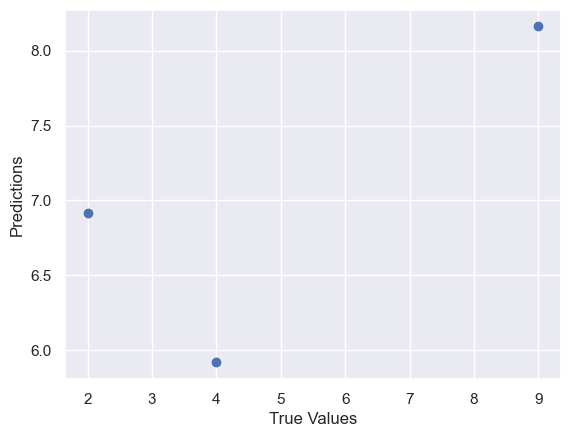

In [40]:
linear_regression_analysis(data_copy, living_situation_city, interest_e_car)

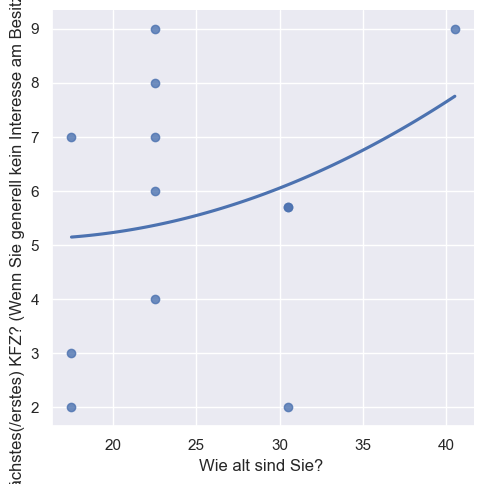

-2.019644524506255


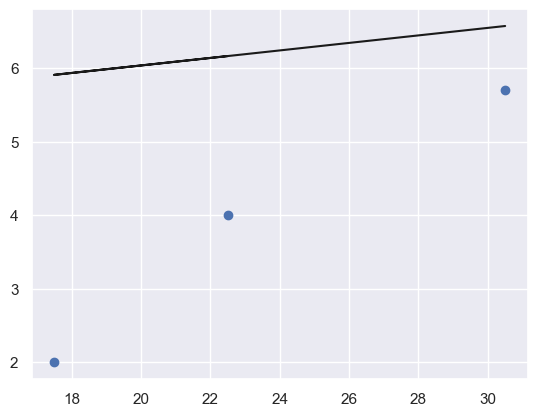

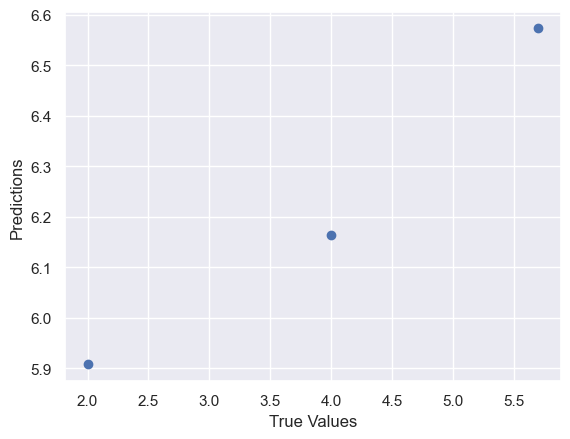

In [41]:
# mobility_car vs interest_e_car
linear_regression_analysis(data_copy, mobility_car, interest_e_car)

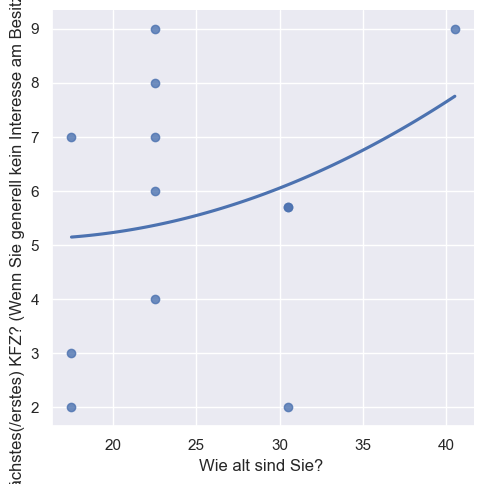

-1.4779934681163183


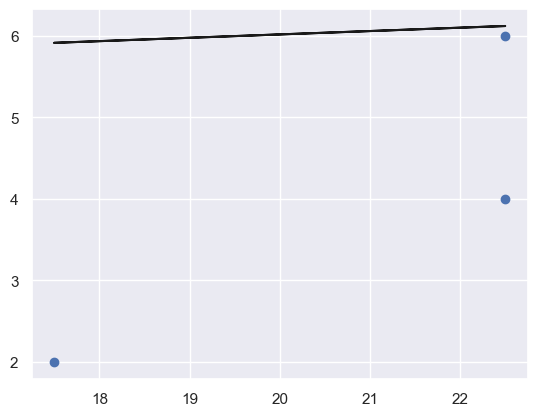

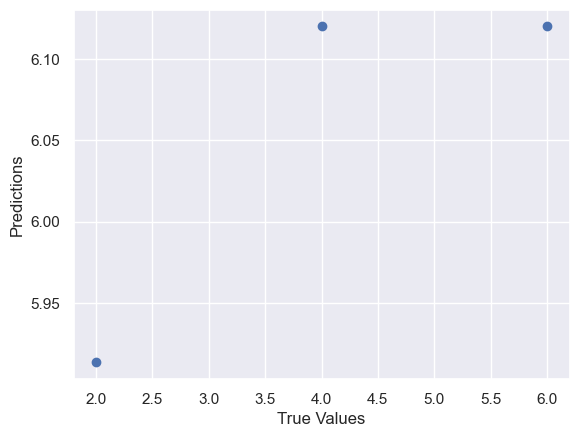

In [42]:
# mobility_public_transport vs interest_e_car
linear_regression_analysis(data_copy, mobility_public_transport, interest_e_car)

-1.0334305293229322


ValueError: x and y must be the same size

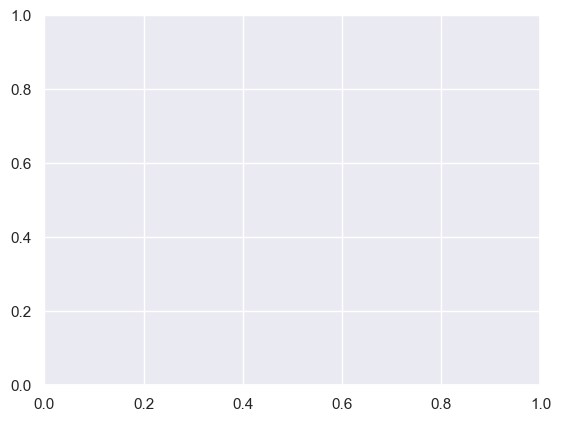

In [43]:
# age, employment vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, employment], interest_e_car)

-1.1180341038890904


ValueError: x and y must be the same size

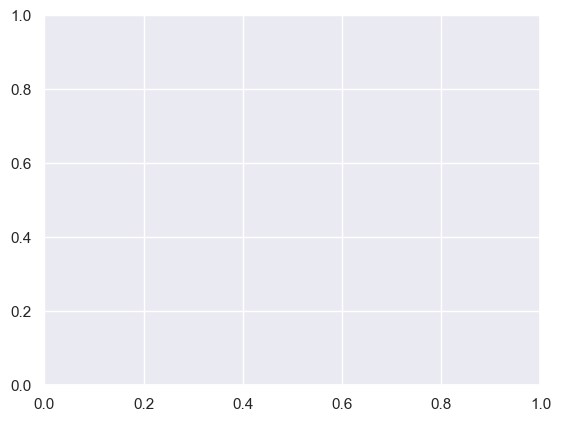

In [44]:
# age, income vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, monthly_income], interest_e_car)

-2.803246186897487


ValueError: x and y must be the same size

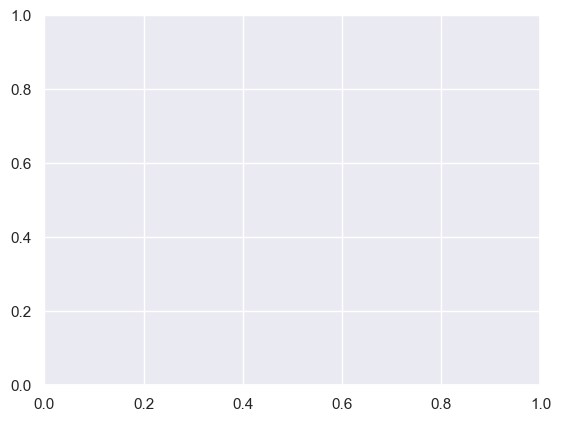

In [45]:
# age, car ownership vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, car_ownership], interest_e_car)

-2.6414486848856926


ValueError: x and y must be the same size

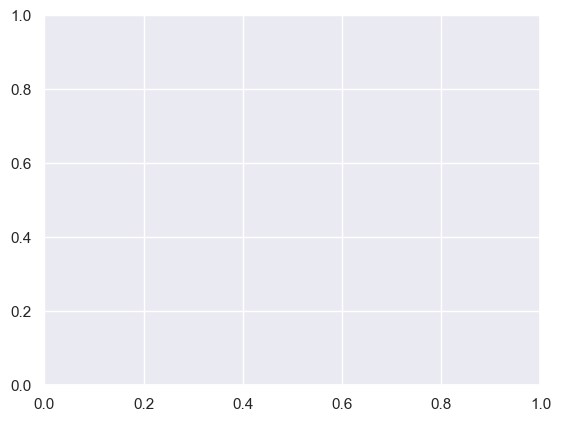

In [46]:
# age, living situation vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation], interest_e_car)

-2.857536636839612


ValueError: x and y must be the same size

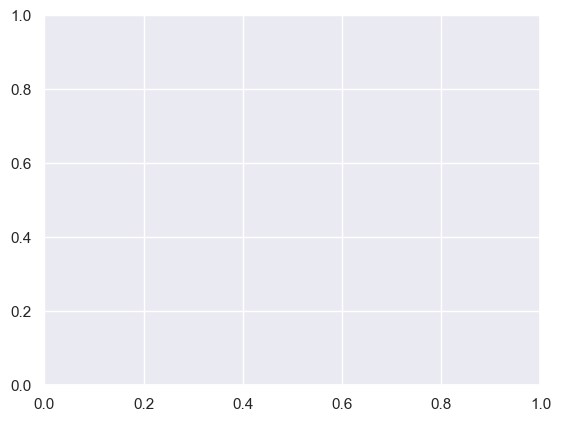

In [47]:
# age, living situation house apartment vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation_house_apartment], interest_e_car)

-1.56697954077057


ValueError: x and y must be the same size

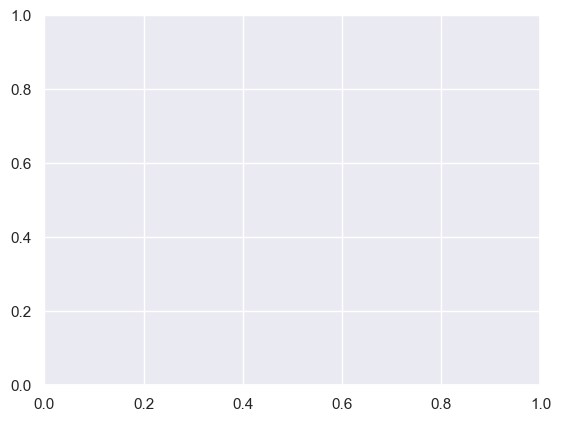

In [48]:
# age, living situation city vs interest_e_car
linear_regression_analysis_multiple_features(data_copy, [age, living_situation_city], interest_e_car)